# Hyperspectral Imaging

## Machine Learning and Computational Statistics, MSc in Data Science (2023/2024)
### Project Assignment

---

> Dimitris Tsirmpas <br>
> MSc in Data Science f3352315 <br>
> Athens University of Economics and Business

In [1]:
from time import time

start = time()

## Exploratory Analysis

### Im
We begin by importing the data. Our data is split in two files:

- `PaviaU_cube.mat`, which depicts the pixels for each image (300x200 resolution) for each of the 103 spectral bands

- `PaviaU_ground_truth.mat` which contains the class labels (materials) for each pixel in the image.

In [2]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt


pavia = sio.loadmat('data/PaviaU_cube.mat')
hsi = pavia['X'] #Pavia HSI : 300x200x103

ends = sio.loadmat('data/PaviaU_endmembers.mat') # Endmember's matrix: 103x9
endmembers = ends["endmembers"]

In [3]:
#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth = sio.loadmat('data/PaviaU_ground_truth.mat')
labels = ground_truth['y']
labels.shape

(300, 200)

Each of the 9 materials contains different values for each spectral band. We can see those values in the plot below:

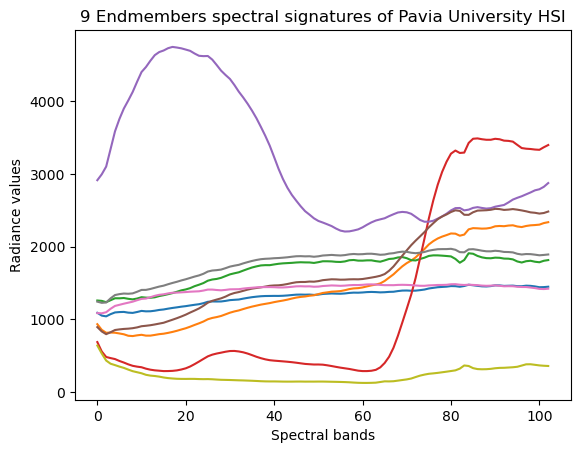

In [4]:
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('9 Endmembers spectral signatures of Pavia University HSI')
plt.show()

These 9 endmembers represent 9 classes of materials, which can be seen in the dictionary below:

In [5]:
class_names = {
    0: "Mixed",
    1: "Water",
    2: "Trees",
    3: "Asphalt",
    4: "Self-Blocking Bricks",
    5: "Bitumen",
    6: "Tiles",
    7: "Shadows",
    8: "Meadows",
    9: "Bare Soil"
}

For this analysis, we need to only keep pure pixels, aka pixels that corresponds to geographical areas with a single geological feature. We thus split our dataset into "classless" aka mixed pixels, and pixels with defined class labels (pure pixels).

In [6]:
mask = labels != 0
pure_hsi = np.where(mask[:,:, None], hsi, 0)

In [7]:
mask = labels == 0
mixed_hsi = np.where(mask[:,:, None] , hsi, 0)

Since our data represent an image we can also show the image for a specific spectral band

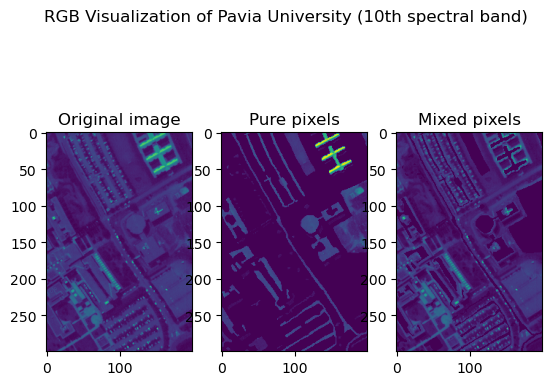

In [8]:
fig, axes = plt.subplots(1, 3)

axes[0].imshow(hsi[:,:,10])
axes[0].set_title("Original image")

axes[1].imshow(pure_hsi[:,:,10])
axes[1].set_title('Pure pixels')

axes[2].imshow(mixed_hsi[:,:,10])
axes[2].set_title('Mixed pixels')

fig.suptitle('RGB Visualization of Pavia University (10th spectral band)')
plt.show()

For demonstration purposes, let's select a pure pixel from the photograph. We select one of the pixels from the top right, from what looks like a building. This area of the photograph appears to have many continuous pure pixels, as seen by the Figure above.

In [9]:
focus_point = (32, 147)
print(f"Focus point is made of {class_names[labels[focus_point]]}")

Focus point is made of Bitumen


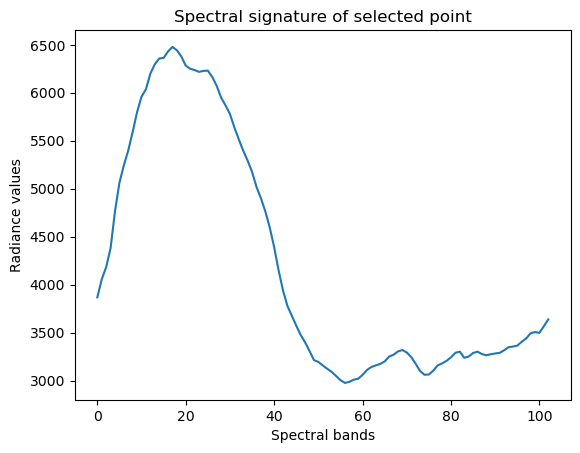

In [10]:
plt.plot(hsi[focus_point])
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title("Spectral signature of selected point")
plt.show()

Notice how similar this spectral signature is to the one defined in the graph above for pixels containing bitumen material.

We could also attempt to make a qqnorm plot for each material on the 1st spectral band:

### Assuming Normality
One of the most important assumptions in Linear Regression models is the assumption of normality. There are three ways of verifying this assumption:

- Running a normality test (such as Shapiro or Jarque-Bera test) on each class
- Building qqnorm plots to graphically gauge the normality of each class
- Assume with a large degree of certainty that the distributions of our classes are very likely to approximate the Normal Distribution under the Central Limit Theorem
- Run the model anyway and assume the distributions are "normal-like" enough if it gives us good results

The first option is unattractive, since normality tests are normally "strong" tests, meaning that with a sufficiently large sample size, the test will almost always assume the distribution is not normal.

The third option can be defended by the size of our data, since each class features a very large number of points $(n_j >> 30, \forall j \in [1,9])$ (where $n_j$ represents the count of the $j$th class):

In [14]:
def split_by_label(data, labels):
    split_arrays = {}

    # Iterate over unique labels and split the array
    for label in np.unique(labels):
        mask = labels == label   # Create a boolean mask for the current label
        split_arrays[label] = data[mask]
    return split_arrays


split_classes = split_by_label(pure_hsi, labels)
for label, array in split_classes.items():
    print(f"Class {class_names[label]}, #Points={len(array)} ")

Class Mixed, #Points=47171 
Class Water, #Points=1108 
Class Trees, #Points=1377 
Class Asphalt, #Points=2099 
Class Self-Blocking Bricks, #Points=609 
Class Bitumen, #Points=698 
Class Tiles, #Points=3042 
Class Shadows, #Points=1330 
Class Meadows, #Points=1795 
Class Bare Soil, #Points=771 


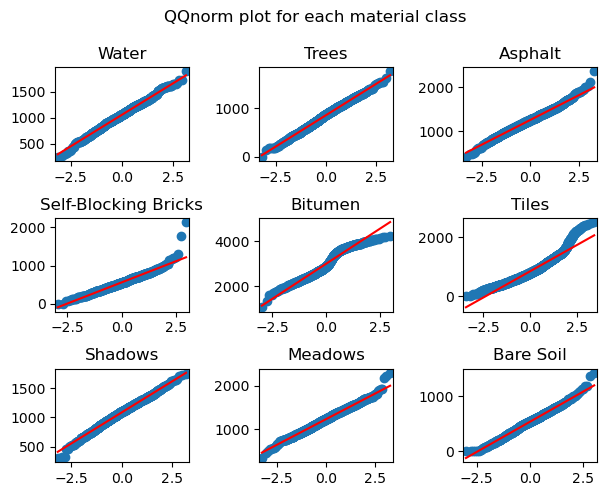

In [15]:
from statsmodels.graphics.gofplots import qqplot


fig, axes = plt.subplots(3, 3)
fig.tight_layout(pad=2.0)
fig.suptitle("QQnorm plot for each material class", y=1.05)

for i, (label_idx, array) in enumerate(split_classes.items()):
    if i != 0:
        idx = i - 1
        ax = axes[idx//3, idx%3]
        qqplot(array[:,1], line="s", ax=ax)
        ax.set_title(class_names[label_idx])
        ax.set_ylabel("")
        ax.set_xlabel("")

plt.show()

Note that the 1st spectral band for all materials but Bitumen and Tiles seem to follow the normal line almost perfectly.

We could repeat this procedure for each of the 103 spectral bands, but for now, this plot does reassure us that the size of our dataset probably is sufficient to assume normality.

## Spectral Unmixing

According to the *linear spectral unmixing hypothesis*, we can assume that every pixel ($y$) in our image is a linear combination of the various spectral signatures ($X$), where each spectral signature contributes a certrain percentage ($\theta$). Since all percentages must sum to one, this would make $\theta$ a *probability distribution function* (pdf), a property which would greately help in interpreting our results.

Under this assumption, the generating distribution for each pixel would be $y = X\theta + \eta, \eta \sim N(0, \sigma^2)$, where $\eta$ represents white noise. This model would be under the following constraints:
- No intercept (which would normally indicate a set % of an "other" material for all pixels)
- $\theta_i > 0, \forall i$
- $\sum_i \theta_i = 1$


We will be considering 4 models, each one following different constraints. Specifically, these will be:
1. An OLS model with no constraints
2. An OLS model with no intercept
3. An OLS model with no intercept and positive coefficients
4. An OLS model with no intercept and positive coefficients which sum to one
5. A LASSO model with no intercept and positive coefficients

Notice that out of the 5 models, only \#4 satisfies the prerequisitives of a pdf.

In [11]:
from prettytable import PrettyTable 


def arrays_stats(arrays: list[np.ndarray], names: list[str]|None = None, decimals: int = 2) -> PrettyTable:
    """
    Generate statistics for a list of NumPy arrays and create a PrettyTable.

    :param arrays: List of NumPy arrays for which statistics are calculated.
    :type arrays: list[np.ndarray]

    :param names: List of names corresponding to each array. If None, default names will be generated based on array indices. Default is None.
    :type names: list[str]|None

    :param decimals: Number of decimals to round the statistical values. Default is 2.
    :type decimals: int

    :return: Table containing statistics for each array, including mean, standard deviation, minimum, maximum, first quartile (Q1), and third quartile (Q3).
    :rtype: PrettyTable
    """
    stats_table = PrettyTable(["Array", "Shape", "Mean", "Std", "Min", "Max", "Q1", "Q3"])
    stats_table.float_format = "."+ str(decimals)

    if type(decimals) is not int:
        raise ValueError("The 'decimals' argument must be an integer.")

    if names is None:
        names = [i for i in range(len(arrays))]

    if len(names) != len(arrays):
        raise ValueError("Names and arrays must have the same length.")

    for name, array in zip(names, arrays):
        stats_table.add_row([name, array.shape, array.mean(),  array.std(),  
                             array.min(), array.max(), 
                             np.quantile(array, 0.25), np.quantile(array, 0.75)])
    return stats_table

In [12]:
# our analysis only concerns pure pixels
mask = labels != 0
y1 = pure_hsi.flatten()[pure_hsi[mask]].T
x1 = endmembers

y1.shape, x1.shape

((103, 12829), (103, 9))

In [13]:
arrays_stats([y1, x1], names=["y1", "x1"])

Array,Shape,Mean,Std,Min,Max,Q1,Q3
y1,"(103, 12829)",530.14,687.91,0,2266,0.00,1369.00
x1,"(103, 9)",1551.32,926.43,128.24,4745.65,1093.66,1897.79


We will also define some convinience functions to analyze the results of each model:

In [16]:
def reconstruction_error(y: np.ndarray, X: np.ndarray, 
                         abundance_map: np.ndarray) -> float:
    """
    Get the reconstruction error for the pure pixels in the image.
    Essentially a Mean Squares Error wrapper for the problem's domain.
    """
    theta = abundance_map
    return np.abs((y - X @ theta.T)).mean()

We will now define and run our models. We will then view and discuss the results in the next section.

### Ordinary Least Squares

In [17]:
from sklearn.linear_model import LinearRegression


base_model = LinearRegression(fit_intercept=True).fit(x1, y1)
base_abundance = base_model.coef_

In [18]:
base_error = reconstruction_error(y1, x1, base_abundance)
base_error

4023.7892601009435

### OLS no intercept, positive coefficients

In [19]:
pos_model = LinearRegression(fit_intercept=False, positive=True).fit(x1, y1)
pos_abundance = pos_model.coef_

In [20]:
pos_error = reconstruction_error(y1, x1, pos_abundance)
pos_error

313.8424774679923

### LASSO, no intercept, positive coefficients

In [21]:
from sklearn.linear_model import Lasso


lasso = Lasso(fit_intercept=False, positive=True, tol=1e-3, max_iter=int(1e5)).fit(x1, y1)
lasso_abundance = lasso.coef_

C:\Users\user\anaconda3\envs\manis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


KeyboardInterrupt: 

In [ ]:
lasso_error = reconstruction_error(y1, x1, lasso_abundance)
lasso_error

### OLS, no intercept, sum-to-one coefficients

In order to enforce the sum-to-one constraint we will build our own function using methods from the `scipy.optimize` module. While there are other solutions, these tend to either be very complicated and hard to modify for our needs (such as the `CVXOPT` package) or not work because of memory constraints / implementation bugs (in this case the `cvxpy` package).

Of note is that the current implementation needs to run a non-negative least squares and a coordinate descent with constraints routine for each one of our points, as the `nnls` function only supports vector calculations. This isn't as inefficient as it may sound, since the cost of the coordinate descent and non-negative least squares routines is proportionally much larger compared to the overhead of calling them for each point. 

Still, the calculation may take some minutes to complete. We could speed it up by assigning each point's calculations to different threads, as the calculation is independent between them. However, we choose to keep the single-threaded code for the sake of clarity and simplicity.

In [ ]:
from tqdm import tqdm
from scipy.optimize import minimize 
from scipy.optimize import nnls 


def lsq_sum_to_one(A: np.ndarray, b: np.ndarray, 
                    bounds :list[list[float|None]], 
                    verbose: bool=True) -> np.ndarray:
    """
    Solve a least squares optimization problem subject to the constraint that the
    sum of the coefficients in each column of the solution matrix is equal to 1.

    Parameters:
    - A (np.ndarray): The coefficient matrix.
    - b (np.ndarray): The target values matrix.
    - bounds (List[List[Union[float, None]]]): Bounds on variables for optimization.
      Each inner list represents the bounds for a corresponding variable.
      A value of None indicates no bound in that direction.
    - verbose (bool, optional): If True, display progress using tqdm. Default is True.

    Returns:
    - np.ndarray: The solution matrix where each column satisfies the sum-to-one constraint.
    """

    coefficients = np.zeros((A.shape[1], b.shape[1]))

    # define minimization function
    min_func = lambda x, A, b: np.linalg.norm(A.dot(x) - b)

    #Define constraints and bounds
    cons = {'type': 'eq', 'fun': lambda x:  np.sum(x)-1}

    iterable = tqdm(range(y1.shape[1])) if verbose else range(y1.shape[1])

    for i in iterable:
        bi = b[:, i]
        #Use nnls to get initial guess
        x0, rnorm = nnls(A, bi)

        #Call minimisation subject to these values
        minout = minimize(min_func, x0, args=(A, bi), method='SLSQP', 
                          bounds=bounds,constraints=cons)
        x = minout.x
        coefficients[:, i] = x

    return coefficients

In [ ]:
sum1_coeffs = lsq_sum_to_one(x1, y1, 9*[[None, None]]).T

Let's confirm that our results do indeed sum up to one:

In [ ]:
sum1_coeffs.shape, np.isclose(sum1_coeffs.sum(axis=1), 1).sum()

In [ ]:
sum1_abundance = sum1_coeffs
sum1_error = reconstruction_error(y1, x1, sum1_abundance)
sum1_error

### OLS, no intercept, positive and sum-to-one coefficients

In [ ]:
pos_sum1_coeffs = lsq_sum_to_one(x1, y1, 9*[[0,None]]).T

We can quickly check that our results satisfy the requirements of a pdf:

In [ ]:
pos_sum1_coeffs.shape, np.isclose(pos_sum1_coeffs.sum(axis=1), 1, 1e-2).sum(), (pos_sum1_coeffs < 0).sum()

There are a few rows which don't exactly add up to 1 (within $\pm 0.01$), which is expected since our algorithm is only approximate to our sum-to-one goal.

In [ ]:
pos_sum1_abundance = pos_sum1_coeffs
pos_sum1_error = reconstruction_error(y1, x1, pos_sum1_abundance)
pos_sum1_error

### Results

A table of the results for each model is presented below. Each row represents a different linear model, and the columns the reconstruction error, as well as the coefficients of the selected pixel we analyzed during the exploratory analysis.

In [ ]:
def add_row(table, name, error, abundance, focus_point=0):
    res_table.add_row([name, error, abundance[focus_point][0], abundance[focus_point][1],
                      abundance[focus_point][2], abundance[focus_point][3], abundance[focus_point][4],
                      abundance[focus_point][5], abundance[focus_point][6], abundance[focus_point][7],
                      abundance[focus_point][8]])


abundance_dim = 9
res_table = PrettyTable(["Model", "Reconstruction Error"] + [f"x{i}" for i in range(1, abundance_dim+1)])
res_table.float_format = ".3"

add_row(res_table, "OLS", base_error, base_abundance)
add_row(res_table, "OLS pos", pos_error, pos_abundance)
add_row(res_table, "LASSO pos", lasso_error, lasso_abundance)
add_row(res_table, "OLS sum-to-1", sum1_error, sum1_abundance)
add_row(res_table, "OLS pos sum-to-1", pos_sum1_error, pos_sum1_abundance)

res_table

A number of observations can be made about our models:

1. The OLS model with no constraints does not lead to a good estimation.
1. The reconstruction error is lowest when we force the coefficients to sum to one, but not necessarily be positive.
1. The OLS with positive coefficients has almost identical results with the LASSO estimator, indicating our problem does not need any regularization. 
1. The OLS modeling a pdf (positive coefficients summing up to one) leads to a slightly larger error than the one without the positive constraint.

From these observations we conclude that:

The Linear Spectral Unmixing hypothesis seems to hold for our problem. This isn't surprising, since this hypothesis often holds and is widely used in practice `[1,2]`.

This conclusion is evident from the fact that our models generally become more efficient the more constraints we place on them, as well as from the fact that regularization appears uneccessary. This could be interpreted as selecting a very good prior for our regression problem, which effectively acts as an equivalent regualarization technique.

We can also trust that our pdf modeling approach is sufficient for our problem. We can thus use the estimates provided by our model to confidently model unmixed pixels in % terms of pure pixels.

`[1] Jiaojiao Wei, Xiaofei Wang, "An Overview on Linear Unmixing of Hyperspectral Data", Mathematical Problems in Engineering, vol. 2020, Article ID 3735403, 12 pages, 2020. https://doi.org/10.1155/2020/3735403`

`[2] Jan G.P.W. Clevers, Raul Zurita-Milla, 3 - Multisensor and multiresolution image fusion using the linear mixing model, Image Fusion, Academic Press, 2008, Pages 67-84, ISBN 9780123725295, https://doi.org/10.1016/B978-0-12-372529-5.00004-4 (https://www.sciencedirect.com/science/article/pii/B9780123725295000044)`

## Classification

We will attempt to classify pure pixels in the image. 

We will import the pixel labels. These represent the training, test and operational sets. The latter represents data we would normally acquire after having trained and tested our classifiers, and thus will not be used in this project. 

In [ ]:
# Trainining set for classification 
Pavia_labels = sio.loadmat('data/classification_labels_Pavia.mat')
y_train_set = (np.reshape(Pavia_labels['training_set'],(200,300))).T
y_test_set = (np.reshape(Pavia_labels['test_set'],(200,300))).T
y_oper_set = (np.reshape(Pavia_labels['operational_set'],(200,300))).T

arrays_stats([y_train_set, y_test_set, y_oper_set], names=["Train", "Test", "Operational"])

The label sets also act as masks, each containing only a subset of the original picture. We can use that to obtain the training, test and operation data from our original picture as follows:

In [ ]:
mask = y_train_set != 0
x_train = hsi[mask]
y_train = y_train_set[mask].flatten()

x_train.shape, y_train.shape

In [ ]:
mask = y_test_set != 0
x_test = hsi[mask]
y_test = y_test_set[mask].flatten()

x_test.shape, y_test.shape

In [ ]:
mask = y_oper_set != 0
x_oper = hsi[mask]
y_oper = y_oper_set[mask].flatten()

x_oper.shape, y_oper.shape

Notice how there is a 2:1 train to test ratio, which is atypical of most Machine Learning tasks (a 80%-20% split is much more widely accepted).

Since the labels and data still represent image pixels, we can clearly visualize the classes in our image:

In [ ]:
import seaborn as sns


ax = sns.heatmap(y_train_set.astype(int), 
                 cmap=sns.color_palette("cubehelix", as_cmap=True),
                 cbar_kws={"boundaries": np.arange(y_train_set.min(), y_train_set.max()+1, 1)})

ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(left=False, bottom=False)

cbar = ax.collections[0].colorbar
cbar.set_ticklabels(class_names.values())

plt.title("Pixel classes in the HSI image")
plt.show()

We will be considering the following estimators:

- Naive Bayes
- Minimum Euclidean Distance
- Bayesian Classifier
- K-Nearest Neighbours

Each model will be evaluated based on 10-K cross validation. We will then train the classifier with all available data to get the training accuracy and confusion matrix.

In [ ]:
def confusion_matrix(true_labels, predicted_labels):
    """
    Construct the confusion matrix for a classifier.

    Parameters:
    - true_labels: numpy array of true labels
    - predicted_labels: numpy array of predicted labels
    - num_classes: number of classes in the classification problem (optional)

    Returns:
    - confusion_matrix: numpy array representing the confusion matrix
    """
    num_classes = max(np.max(true_labels), np.max(predicted_labels)) + 1

    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for true, pred in zip(true_labels, predicted_labels):
        confusion_matrix[true, pred] += 1

    return confusion_matrix

In [ ]:
def get_accuracy(confusion_matrix: np.ndarray) -> float:
    """
    Calculate the accuracy from a confusion matrix.

    :param confusion_matrix: A 2D NumPy array representing a confusion matrix.
    :type confusion_matrix: np.ndarray

    :return: The accuracy calculated from the confusion matrix.
    :rtype: float
    """
    return confusion_matrix.diagonal().sum() / confusion_matrix.sum()

In [ ]:
def conf_matrix_heatmap(name, conf_matrix, ax=None):
    sns.heatmap(conf_matrix, 
                cmap=sns.color_palette("light:b", as_cmap=True),
                cbar_kws={'label': "Instances Categorized"},
                annot=True, 
                fmt="d", 
                linewidths=.5,
                xticklabels=class_names.values(),
                yticklabels=class_names.values(), 
                ax=ax)
    plt.title(name)

### Naive Bayes

In [ ]:
from sklearn.model_selection import cross_val_score


def cross_val_res(model, x, y, scoring=None):
    res = cross_val_score(model, x, y, cv=10, scoring=scoring)
    return res.mean(), res.std()

In [ ]:
from sklearn.naive_bayes import GaussianNB


res = cross_val_res(GaussianNB(), x_train, y_train)
print(f"Naive Bayes mean accuracy {res[0]:.4f}, std: {res[1]:.4f}")

In [ ]:
naive_model = GaussianNB().fit(x_train, y_train)
naive_train_res = naive_model.predict(x_train)
naive_test_res = naive_model.predict(x_test)

naive_conf = confusion_matrix(naive_test_res, y_test)
conf_matrix_heatmap("Naive Bayes Confusion Matrix", naive_conf)

In [ ]:
naive_conf_train = confusion_matrix(naive_train_res, y_train)
print(f"Naive Bayes \nTraining Accuracy: {get_accuracy(naive_conf_train):.3f}\nTesting Accuracy: {get_accuracy(naive_conf):.3f}")

### Minimum Euclidean Distance

The Minimum Euclidean Distance classifier is a variant of the Bayesian Classifier, where we assume our data have the same variance across all axes, as well as each dimension being statistically independent from each other. Graphically, this would be represented as circles with equal radii, which according to the Figure containing the image classes, does not seem to be the case here.

Under this assumption, the optimal classification for a point $x$ would be the equivalent to finding the minimum euclidean distance between it and the $\mu_j \forall j$, representing the means of each class $j$.

In [ ]:
from sklearn.base import BaseEstimator


class EuclideanDistanceClassifier(BaseEstimator):

    def __init__(self):
        self.means_labels = []
        self.means = []

    def fit(self, x_train, y_train):
        self.means_labels = np.unique(y_train)

        for label in self.means_labels:
            data = x_train[y_train == label]
            self.means.append(data.mean(axis=0))

        return self

    def predict(self, x):
        preds = []

        for point in x:
            distances = []

            for label in self.means_labels:
                distances.append(np.linalg.norm(point - self.means[label-1]))

            min_dist = np.argmin(distances)
            preds.append(self.means_labels[min_dist])

        return np.array(preds)

In [ ]:
res = cross_val_res(EuclideanDistanceClassifier(), x_train, y_train, scoring="f1_weighted")
print(f"Minimum Euclidean Distance Mean accuracy: {res[0]:.4f}, std: {res[1]:.4f}")

In [ ]:
euclid_model = EuclideanDistanceClassifier().fit(x_train, y_train)

euclid_train_res = euclid_model.predict(x_train)
euclid_test_res = euclid_model.predict(x_test)

euclid_conf = confusion_matrix(euclid_test_res, y_test)
conf_matrix_heatmap("Minimum Euclidean Distance Confusion Matrix", euclid_conf)

In [ ]:
euclid_train_conf = confusion_matrix(euclid_train_res, y_train)
print(f"Minimum Euclidean Distance \nTraining Accuracy: {get_accuracy(euclid_train_conf):.3f}\nTesting Accuracy: {get_accuracy(euclid_conf):.3f}")

### K-Nearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


k = 5
res = cross_val_res(KNeighborsClassifier(n_neighbors=k), x_train, y_train)
print(f"{k}-NN mean accuracy {res[0]:.4f}, std: {res[1]:.4f}")

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5).fit(x_train, y_train)

knn_train_res = knn_model.predict(x_train)
knn_test_res = knn_model.predict(x_test)
knn_conf = confusion_matrix(knn_test_res, y_test)

conf_matrix_heatmap(f"{k}-NN Confusion Matrix", knn_conf)

In [ ]:
knn_conf_train = confusion_matrix(knn_train_res, y_train)
print(f"{k}-Nearest Neighbours \nTraining Accuracy: {get_accuracy(knn_conf_train):.3f}\nTesting Accuracy: {get_accuracy(knn_conf):.3f}")

### Bayes Classifier

The general Bayes Classifier, as opposed to the Minimum Euclidean Distance Classifier, makes no assumptions in regards to the variances and covariances (statistical dependencies) between the data's dimensions, and thus is a more flexible classifier. 

This classifier can be proven to be optimal in regards to the classification error, provided we know the generating probability density functions (pdfs). Since, this is impossible in most real world applications, these need to be estimated, and we thus must make some assumptions about the class distributions.

The most commonly used Bayesian Classifier is the *Mutlinomial Guassian Bayesian Classifier*. 

`sklearn`'s equivalent models are the  Linear Discriminant Analysis and Quadratic Discriminant Analysis estimators. The Figure below demonstrates the assumed data distributions (the two ellipses), their means (stars) and the decision surfaces for each class (blue and red areas) for both of these models. 

- The Linear Discriminant Analysis estimator assumes that both classes follow Gaussian (normal) distributions with different means and same covariances, in which case the optimal decision surface is a line. This is depicted graphically as the two classes having the same shape and being spread in the same direction. 

- The Quadratic Discriminant Analysis estimator assumes that both classes follow Gaussian (normal) distributions but with different means AND different covariances, meaning that our classes may feature different normal-like shapes.

![qda](resources/qda.png)

*Picture taken from https://scikit-learn.org/stable/modules/lda_qda.html Accessed 22/11/2023*.

Choosing between the two available Bayesian Classifiers, we pick the Quadratic Discriminant Analysis estimator. As stated above, QDA works best when the classes have different (normal) shapes, and its decision surfaces or graphically can be represented by curves splitting each class from the others. This seems to be the case according to our Figure featuring our own classes in the image, and thus QDA will probably be a good fit.

By choosing QDA as our Bayesian Classifier, we make one important assumption towards our data: that each class is, or sufficiently approximates, a normal distribution. We can make this assumption relatively safely, as discussed in the Exploratory Analysis Section.

We thus run our Bayesian Classifier with unequal variances:

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


res = cross_val_res(QuadraticDiscriminantAnalysis(), x_train, y_train)
print(f"Bayesian mean accuracy {res[0]:.4f}, std: {res[1]:.4f}")

In [ ]:
bayes_model = QuadraticDiscriminantAnalysis().fit(x_train, y_train)

bayes_train_res = bayes_model.predict(x_train)
bayes_test_res = bayes_model.predict(x_test)
bayes_conf = confusion_matrix(bayes_test_res, y_test)

conf_matrix_heatmap("Bayesian Confusion Matrix", bayes_conf)

In [ ]:
bayes_conf_train = confusion_matrix(bayes_train_res, y_train)
print(f"Bayesian Classifier \nTraining Accuracy: {get_accuracy(bayes_conf_train):.3f}\nTesting Accuracy: {get_accuracy(bayes_conf):.3f}")

### Comparing the classifiers

In [ ]:
fig, axes = plt.subplots(2, 2)

conf_matrix_heatmap("", confusion_matrix(naive_test_res, y_test), ax=axes[0,0])
axes[0,0].set_title("Naive Bayes Confusion Matrix")

conf_matrix_heatmap("", confusion_matrix(euclid_test_res, y_test), ax=axes[0,1])
axes[0,1].set_title("Minimum Euclidean Distance Confusion Matrix")

conf_matrix_heatmap("", confusion_matrix(knn_test_res, y_test), ax=axes[1,0])
axes[1,0].set_title(f"{k}-NN Confusion Matrix")

conf_matrix_heatmap("", confusion_matrix(bayes_test_res, y_test), ax=axes[1,1])
axes[1,1].set_title("Bayesian Confusion Matrix")


fig.set_size_inches(16, 12)
plt.tight_layout(pad=2)
plt.show()

By comparing the Confusion matrices between the different classifiers we can make the following observations:

- Naive Bayes has great difficulty distinguishing between Tiles-Trees, as well as Asphalt-Meadows and Water-Shadows.
- The Minimum Euclidean Classifier is generally very easily confused, as we can see major deviations from the matrix diagonal. It does however perform well when classifying Bare Soil and Self Blocking Bricks.
- The 5-NN Classifier performs very well, being very accurate with almost all materials. We see some confusion in regards to Asphalt and Meadows.
- The Bayesian Classifier also performs very well, with innaccuracies being recorded on the same materials as the 5-NN model. This probably indicates that the Asphalt and Meadows are not well separable from their spectral signatures in general.

## Spectral Unmixing and Classification: Possible Correlations

The results obtained from spectral unmixing (SU), which was posed here as a regression problem, and classification in hyperspectral image (HSI) analysis can be correlated, as both approaches provide information about the materials present in a given pixel.

###  Complementary Information

Spectral Unmixing provides sub-pixel information by estimating the abundance of pure materials within a mixed pixel, while classification simply assigns each pixel to a specific class.

The results of spectral unmixing can thus complement the information obtained through classification. While classification provides a discrete label for each pixel, spectral unmixing provides continuous abundance values, indicating the % contribution of different materials within a given pixel. 

Thus, should classification produce fuzzy or unreliable results in any parts of the image, Spectral Unmixing can help in interpreting these areas with the extra information it provides. 


### Handling Mixed Pixels

Spectral Unmixing is specifically designed to handle mixed pixels by decomposing them into their constituent pure materials, while classification may struggle with mixed pixels, as it assigns a single class label to each pixel, potentially overlooking the presence of multiple materials.

In this project we specifically only focused on pure pixels. As we can see from our data however, real world problems most of the time need to handle mixed pixels. The abundance of mixed pixels is described in van der Meer (1999) `[3]` where according to the author:

```
Reflected radiation from a pixel as observed in remote sensing  imagery, however, has rarely interacted with a volume composed of a single homogenous material because natural surfaces and vegetation  composed of a single uniform material do not exist. Most often the electromagnetic radiation observed as pixel reflectance values results from the spectral mixture of a number of ground spectral classes present at the surface sensed.
```

In these cases, spectral unmixing can help in understanding the content of mixed pixels, and the results can guide the classification process. For example, if a pixel is found to have significant abundances of multiple materials, it may be more appropriately assigned to a mixed class during classification.

Additionally, the aforementioned mixed classified pixels could be then given to a SU algorithm in order to obtain more information on the materials present in the mix.

### Derived end-member selection

Conversly, the classes generated from the classification algorithm can be used as labels in the SU task in order to derive better spectral signatures. This task is called "end-member selection", and is described by van der Meer (1999) `[3]` as:

```
A set of end-members should allow to describe all spectral variability for all pixels, produce unique results, and be of significance to the underlying science objectives.

Selection of end-members can be achieved in two ways:
1. from a spectral (field or laboratory) library, and
2. from the purest pixels in the image.

The second method has the advantage that selected end-members were collected under similar atmospheric conditions. End-members resulting through the first option are generally denoted as ‘known’, while those from the second option results are known as ‘derived’ end-members
```
which traditionally was performed using techniques such as PCA.

### Summary 
In summary, spectral unmixing and classification are complementary techniques that can be used together to obtain a more comprehensive understanding of hyperspectral data. Spectral unmixing provides detailed sub-pixel information, especially for mixed pixels, while classification assigns discrete labels to pixels. Besides allowing a richer interpretation of the HSI, these techniques can generate data used by the other to collaboratively enhance their results (better interepretation in classification and more accurate end-member selection in SU).


`[3] van der Meer, F. (1999). Image classification through spectral unmixing. In Spatial Statistics for Remote Sensing (pp. 185-193). Dordrecht: Springer Netherlands.`

In [ ]:
print(f"Notebook executed in {int((time()-start)// 60)} minutes and {(time()-start) % 60:.1f} seconds")